# Sandbox for CLTV analysis

In [1]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../../'))

import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax_cltv.datasets.dummy import DummySubscriptions
from jax_cltv.models.mle import MLE
from jax_cltv.dists.geom import Geometric, neg_loglikelihood
from jax_cltv.plots.plot_data import plot_churns, plot_survives

plt.style.use('bmh')

/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def init_variables(to_delete: list) -> None:
    for v in to_delete:
        try: 
            del v
        except:
            pass

In [3]:
theta_true = 0.2

# ds, data = DummySubscriptions(p=.2, size=1000)()
ds, data = DummySubscriptions(p=theta_true, size=1000, noise={'lam': 0.5})()

In [4]:
data.shape

(1000, 30)

In [5]:
df = ds.to_pandas()

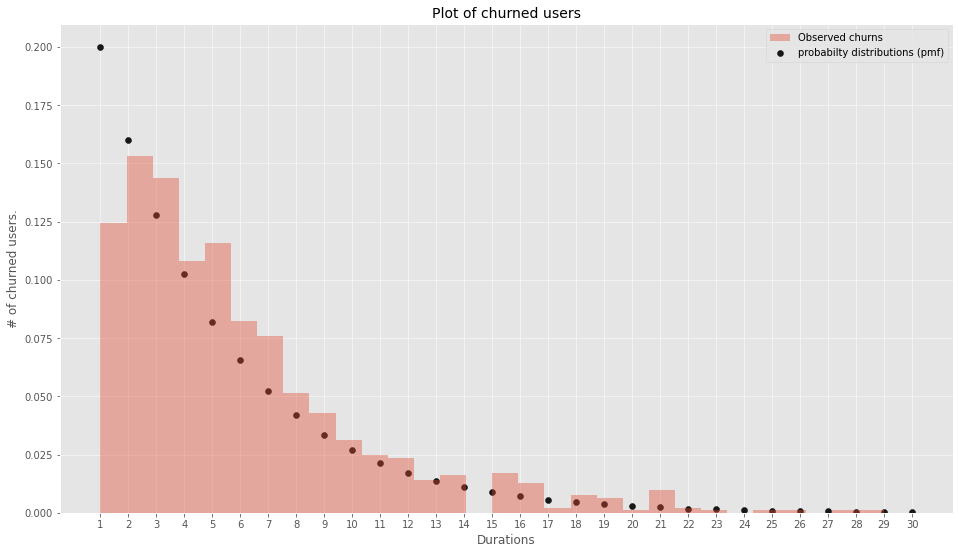

In [6]:
ax = plot_churns(df, theta=.2, density=True)
plt.show()

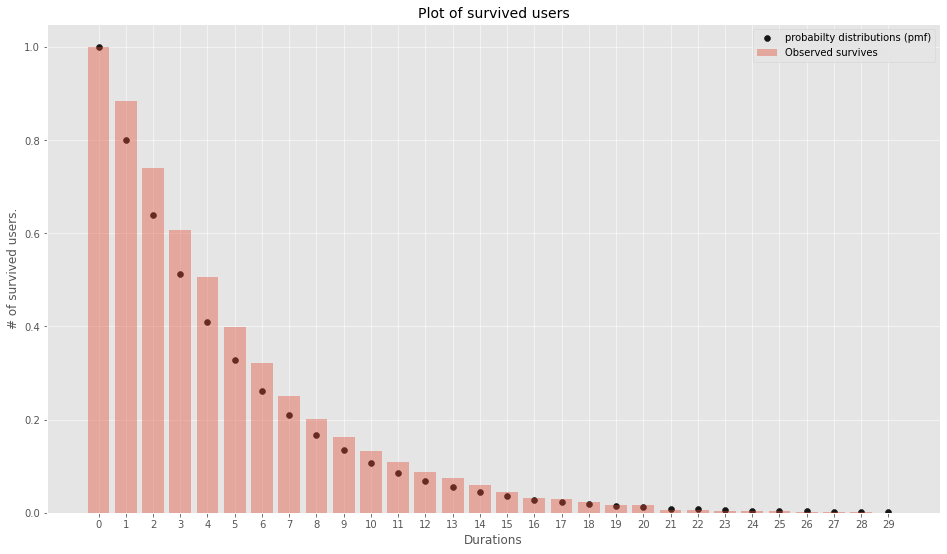

In [7]:
ax = plot_survives(df, theta=.2, density=True)
plt.show()

## Inference with MLE

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1)

In [10]:
y_train = df_train.sum(axis=1).astype('int')
y_test = df_test.sum(axis=1).astype('int')

In [11]:
print(f'Training data: {y_train.shape}')
print(f'Test data: {y_test.shape}')

Training data: (700,)
Test data: (300,)


In [12]:
def model():
    return MLE(dist=Geometric(0.8))

def loss(w, x, y):
    nl, _ = neg_loglikelihood(x, w[0])
    return nl

In [13]:
init_variables(['m', 'res'])

m = model()
w_init = jnp.array(list(m.params.values()))
res = m.fit(loss, w_init, (jnp.array(y_train), None))

In [14]:
res.params

DeviceArray([0.17820828], dtype=float32)

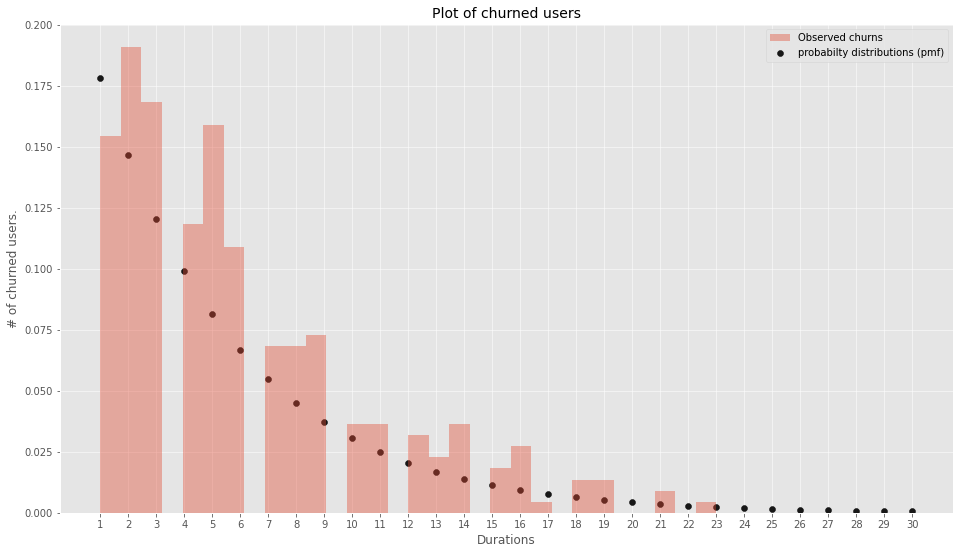

In [15]:
ax = plot_churns(df_test, theta=res.params, density=True)
plt.show()

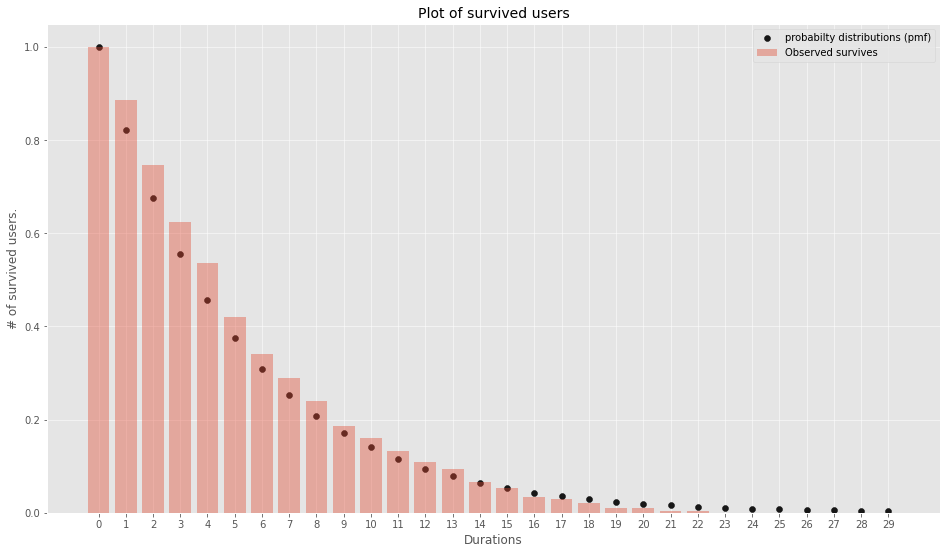

In [16]:
ax = plot_survives(df_test, theta=res.params, density=True)
plt.show()

In [17]:
from jax.scipy.stats import geom

In [18]:
m = 100
d = 0.15

In [19]:
def calc_revenues(row, df, key, m, d):
    idx = df[df[key]==row].index[0]
    return  (m/(1 + d)**idx) * row


def calc_cltv(theta, d, m, T):
    N, D = df.shape
    dcf = []
    s = []

    def churn(theta, t):
        return (1-theta)**(t-1) * theta

    def survive(theta, t):
        return (1-theta)**t

    for t in range(T+1):
        s.append(survive(theta, t))
        dcf.append((1/(1+d)**t))
        # if t == 0:
        #     s.append(1)
        #     dcf.append(1)
        # else:
        #     s.append(survive(theta, t))
        #     dcf.append((1/(1+d)**t))

    clv = m * np.sum([x * y for x, y in zip(s, dcf)])
    return clv

In [20]:
def get_df_cltv(df, m, d, theta):
    N, D = df.shape
    df_cltv = pd.concat([
        pd.DataFrame({'observed_churns': df.sum(axis=1).value_counts()}),
        pd.DataFrame({'pmf_churn_rate': geom.pmf(jnp.array(range(D)), theta)})
    ], axis=1)
    df_cltv.fillna(0, inplace=True)
    df_cltv['observed_survives'] = N - df_cltv['observed_churns'].cumsum()
    df_cltv['ob_churn_rate'] = df_cltv['observed_churns'] / N
    df_cltv['ob_survive_rate'] = df_cltv['observed_survives'] / N
    df_cltv['pmf_survive_rate'] = 1 - df_cltv['pmf_churn_rate'].cumsum()
    df_cltv['day'] = df_cltv.index.map(lambda x: f'Day{int(x)}')
    df_cltv['ob_monetization'] = df_cltv['ob_survive_rate'].map(
        lambda x: calc_revenues(x, df_cltv, 'ob_survive_rate', m, d))
    df_cltv['ob_cltv'] = df_cltv['ob_monetization'].cumsum()

    return df_cltv

In [21]:
df_cltv = get_df_cltv(df_test, m, d, res.params)
df_cltv['modeled_cltv'] = df_cltv.index.map(
    lambda r: calc_cltv(res.params, d, m, int(r)))

In [22]:
df_cltv

,observed_churns,pmf_churn_rate,observed_survives,ob_churn_rate,ob_survive_rate,pmf_survive_rate,day,ob_monetization,ob_cltv,modeled_cltv
0.0,0.0,0.000000,300.0,0.000000,1.000000,1.000000,Day0,100.000000,100.000000,100.000000
1.0,34.0,0.178208,266.0,0.113333,0.886667,0.821792,Day1,77.101449,177.101449,171.460152
2.0,42.0,0.146450,224.0,0.140000,0.746667,0.675342,Day2,56.458727,233.560176,222.525692
3.0,37.0,0.120351,187.0,0.123333,0.623333,0.554990,Day3,40.985178,274.545355,259.017181
4.0,26.0,0.098904,161.0,0.086667,0.536667,0.456086,Day4,30.684091,305.229446,285.094070
5.0,35.0,0.081278,126.0,0.116667,0.420000,0.374808,Day5,20.881423,326.110869,303.728652
6.0,24.0,0.066794,102.0,0.080000,0.340000,0.308014,Day6,14.699138,340.810007,317.044950
7.0,15.0,0.054891,87.0,0.050000,0.290000,0.253123,Day7,10.902174,351.712181,326.560783
8.0,15.0,0.045109,72.0,0.050000,0.240000,0.208015,Day8,7.845643,359.557824,333.360815
9.0,16.0,0.037070,56.0,0.053333,0.186667,0.170945,Day9,5.306232,364.864055,338.220143


In [23]:
df_cltv.head()


,observed_churns,pmf_churn_rate,observed_survives,ob_churn_rate,ob_survive_rate,pmf_survive_rate,day,ob_monetization,ob_cltv,modeled_cltv
0.0,0.0,0.000000,300.0,0.000000,1.000000,1.000000,Day0,100.000000,100.000000,100.000000
1.0,34.0,0.178208,266.0,0.113333,0.886667,0.821792,Day1,77.101449,177.101449,171.460152
2.0,42.0,0.146450,224.0,0.140000,0.746667,0.675342,Day2,56.458727,233.560176,222.525692
3.0,37.0,0.120351,187.0,0.123333,0.623333,0.554990,Day3,40.985178,274.545355,259.017181
4.0,26.0,0.098904,161.0,0.086667,0.536667,0.456086,Day4,30.684091,305.229446,285.094070


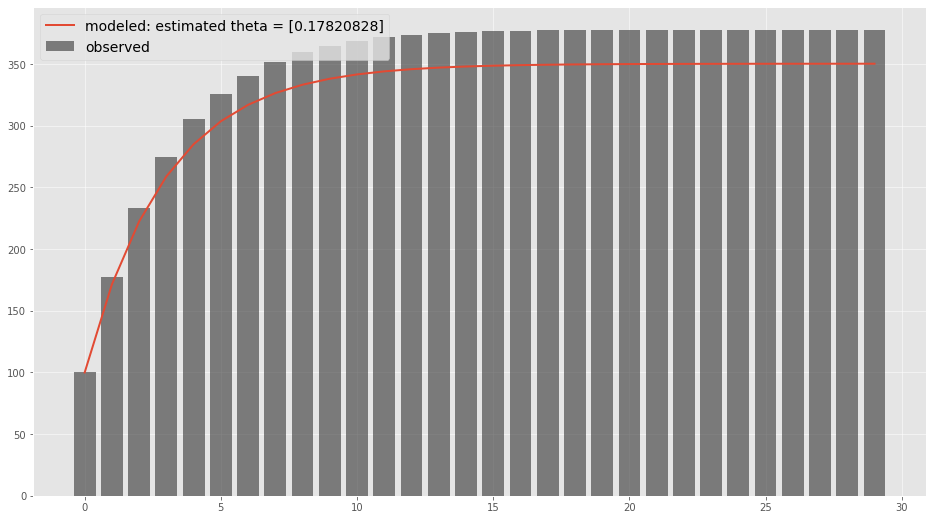

In [24]:
fig = plt.figure(figsize=(16, 9))
plt.bar(df_cltv.index, df_cltv['ob_cltv'], label='observed', color='#333333', alpha=.6)
plt.plot(df_cltv.index, df_cltv['modeled_cltv'], label=f'modeled: estimated theta = {res.params}')
plt.legend(fontsize=14)
plt.show()

In [25]:
print(f'Average retention days based on the true parameter: {1/theta_true}')
print(f'Average retention days based on the training data: {df_train.sum(axis=1).mean()}')
print(f'Average retention days based on the test data: {df_test.sum(axis=1).mean()}')
print(f'Average retention days based on an inferenced parameter: {1/res.params.to_py()}')

Average retention days based on the true parameter: 5.0
Average retention days based on the training data: 5.611428571428571
Average retention days based on the test data: 5.996666666666667
Average retention days based on an inferenced parameter: [5.6114116]
